In [1]:
#  Importando as bibliotecas que serão utilizadas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.optim import SGD, Adam

In [2]:
# Lendo o arquivo e ajustando as informações do dataset
class CSVDataset(Dataset):
    def __init__(self,path):
        data = pd.read_csv('House_Rent_Dataset.csv', header =0, index_col=0)

        # Categorizando os tamanhos do imóvel por faixa de tamanho

        conditions = [
            (data["Size"] <= 600),
            (data["Size"] > 600) & (data["Size"] <= 1500),
            (data["Size"] > 1500) & (data["Size"] <= 3000),
            (data["Size"] > 3000)
            ]

        # Criando uma lista de valores para atribuir a cada "categoria" de tamanho
        values = ["pequeno", "médio", "grande", "super"]


        # criando uma nova coluna com os valores atribuídos
        data["Tamanho"] = np.select(conditions, values)

        
        # Categorizando os valores de aluguel por faixa de valor

        conditions = [
            (data["Rent"] <= 2000),
            (data["Rent"] > 2000) & (data["Rent"] <= 3000),
            (data["Rent"] > 3000) & (data["Rent"] <= 4000),
            (data["Rent"] > 4000) & (data["Rent"] <= 5000),
            (data["Rent"] > 5000) & (data["Rent"] <= 6000),
            (data["Rent"] > 6000) & (data["Rent"] <= 7000),
            (data["Rent"] > 7000) & (data["Rent"] <= 8000),
            (data["Rent"] > 8000) & (data["Rent"] <= 9000),
            (data["Rent"] > 9000) & (data["Rent"] <= 10000),
            (data["Rent"] > 10000)
            ]

        # Criando uma lista de valores para atribuir a cada "categoria" de valor
        values = ["0-2000", "2001-3000","3001-4000","4001-5000", "5001-6000", "6001-7000","7001-8000","8001-9000","9001-10000", "10000+"]


        # criando uma nova coluna com os valores atribuídos
        data["Aluguel"] = np.select(conditions, values)
        
        tipo_area = data["Area Type"].values
        labelencoder_tipo_area = LabelEncoder()
        tipo_area = labelencoder_tipo_area.fit_transform(tipo_area)

        data["Area Type"] = tipo_area

        #  Discretizando a cidade (City) - usando o Label Encoder.

        cidade = data["City"].values
        labelencoder_cidade = LabelEncoder()
        cidade = labelencoder_cidade.fit_transform(cidade)

        data["City"] = cidade

        #  Discretizando o tamanho - usando o Label Encoder.

        tamanho = data["Tamanho"].values
        labelencoder_tamanho = LabelEncoder()
        tamanho = labelencoder_tamanho.fit_transform(tamanho)

        data["Tamanho"] = tamanho


        #  Discretizando as categorias dos valores de aluguel - usando o Label Encoder.

        aluguel = data["Aluguel"].values
        labelencoder_aluguel = LabelEncoder()
        aluguel = labelencoder_aluguel.fit_transform(aluguel)

        data["Aluguel"] = aluguel
        
        
#         Retirando as colunas que não serão utilizadas
        data.drop(["Tenant Preferred", "Point of Contact", "Furnishing Status", "Size", "Rent", "Area Locality", "Floor"], axis=1, inplace=True)
        

        
        self.X = data.values[:,:-1]
        self.y = data.values[:, -1]

        
        self.X = self.X.astype('float32')
        
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return [self.X[idx], self.y[idx]]

dataset = CSVDataset(pd.read_csv('House_Rent_Dataset.csv', header =0, index_col=0))
        

In [3]:
# Verificando o número de tuplas(features e classes) e visualizando o index 0
# do dataset

print('Número de tuplas:' , dataset.__len__())

print(dataset[0])


Número de tuplas: 4746
[array([2., 2., 4., 2., 1.], dtype=float32), array([9.], dtype=float32)]


In [4]:
# Verificando os valores de X(features) e y(classes) do dataset

for i in range(2):
    print(dataset.X[i], dataset.y[i])

[2. 2. 4. 2. 1.] [9.]
[2. 2. 4. 1. 1.] [1.]


In [5]:
# Definindo a porcentagem do dataset que será utilizada para teste e treino
# Usando o módulo random_split do Pytorch

train_len = int(0.7*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset,[train_len,test_len], generator=torch.Generator().manual_seed(123),)

In [6]:
# Utilizando o DataLoader

train = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
X_train, y_train = next(iter(train))

print(X_train)
print(y_train)

tensor([[2., 1., 1., 2., 1.],
        [2., 1., 3., 2., 2.],
        [2., 1., 5., 2., 2.],
        [3., 2., 3., 3., 0.],
        [3., 2., 4., 3., 1.],
        [2., 2., 3., 3., 1.],
        [1., 2., 3., 1., 2.],
        [3., 1., 3., 3., 1.],
        [3., 2., 2., 4., 3.],
        [3., 1., 4., 2., 1.],
        [1., 2., 2., 1., 2.],
        [2., 2., 4., 1., 1.],
        [2., 2., 1., 2., 1.],
        [3., 1., 5., 4., 1.],
        [1., 2., 5., 1., 2.],
        [2., 2., 3., 2., 1.],
        [1., 1., 2., 1., 2.],
        [2., 2., 4., 2., 1.],
        [3., 1., 5., 3., 1.],
        [2., 2., 3., 2., 1.],
        [3., 1., 2., 3., 0.],
        [1., 2., 5., 1., 2.],
        [1., 2., 1., 2., 1.],
        [1., 1., 5., 1., 2.],
        [3., 1., 0., 3., 0.],
        [2., 2., 1., 2., 0.],
        [1., 2., 0., 1., 2.],
        [2., 1., 4., 1., 1.],
        [1., 2., 0., 1., 2.],
        [1., 2., 5., 1., 2.],
        [1., 1., 4., 1., 2.],
        [1., 2., 0., 1., 2.]])
tensor([[1.],
        [1.],
        [1.

In [8]:
class MLP(nn.Module):
# definindo elementos do modelo
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        
        self.hidden1=nn.Linear(n_inputs,10)
        self.act1 = nn.ReLU()
        
        self.hidden2=nn.Linear(10,8)
        self.act2 = nn.ReLU()
        
        self.hidden3=nn.Linear(8,1)
        self.act3 = nn.Sigmoid()
        
# Forward

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [9]:
# Iniciando o modelo

model = MLP(5)
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

print(model)

print(model)

MLP(
  (hidden1): Linear(in_features=5, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (act3): Sigmoid()
)
MLP(
  (hidden1): Linear(in_features=5, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [10]:
# Definindo o conjunto de treino e verificando a forma dele.

X_train, y_train = next(iter(train))

print(X_train.shape)
print(y_train.shape)

torch.Size([32, 5])
torch.Size([32, 1])


In [11]:
# importando a barra de progresso para acompanhar o andamento
import tqdm

# Treinando o modelo

EPOCHS = 100
loss_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    loss_batch = 0
    
    for x_batch, y_batch in train:
        y_pred = model(x_batch)
        loss= loss_fn(y_pred, y_batch)
        
# Zero gradientes

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss_batch + loss.item()
        
    loss_list[epoch] = loss_batch / len(x_batch)

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


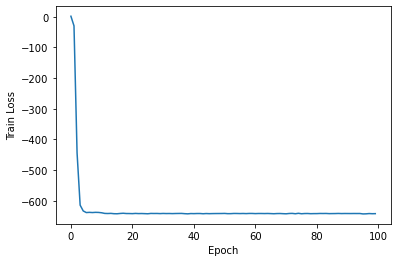

In [12]:
# Verificando e plotando o "loss" em gráfico

def plot_history(loss_list):
    
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.show()
    
plot_history(loss_list)

In [13]:
# Predição

test = DataLoader(test_dataset, batch_size=len(test_dataset))
xx_test, yy_test = next(iter(test))
yy_pred = model(xx_test).round()

In [14]:
# Verificando a acuracidade do modelo.

print(accuracy_score(yy_test.detach().numpy(), yy_pred.detach().numpy()))

0.7155898876404494


In [16]:
# Configurando para utilizar a GPU para processar os tensores e o modelo

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando {}".format(device))

Usando cpu


In [17]:
# Fazendo os tensores passarem a ser excutados no dispositivo indicado

model = MLP(5).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

print(model)

MLP(
  (hidden1): Linear(in_features=5, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (act3): Sigmoid()
)


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


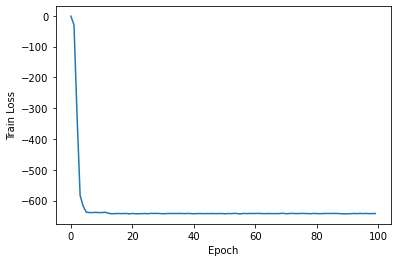

In [18]:
# Movendo os dados de x_batch e y_batch para o mesmo dispositivo do modelo

# Treinando o modelo

EPOCHS = 100
loss_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    loss_batch = 0
    
    for x_batch, y_batch in train:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
# Computando a saída do modelo
        
        y_pred = model(x_batch)
        loss= loss_fn(y_pred, y_batch)

# Zero gradientes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss_batch + loss.item()
        
    loss_list[epoch] = loss_batch / len(x_batch)
    
# Plotando os resultados
plot_history(loss_list)

In [19]:
# Predição

test = DataLoader(test_dataset, batch_size=len(test_dataset))
xx_test, yy_test = next(iter(test))
yy_pred = model(xx_test).round()

# Verificando a acuracidade do modelo.

print(accuracy_score(yy_test.detach().numpy(), yy_pred.detach().numpy()))

0.7155898876404494


In [20]:
# Conclusão:

# Mesmo que tenha ficado pouca coisa maior a acuracidade, em comparação
# com a ánalise utilizando o tensorflow na trilha 4, novamente não consegui 
# chegar a 80%(0.8) de acuracidade :(

# Primeiramente tentei utilizar o modelo de Regressão e o modelo de 
# Classificação para realizar a atividade porém na hora de realizar 
# o treinamento do modelo dava erro, tentei de varias formas consertar
# e não consegui, optei então por seguir com alguma das demais
# técnicas apresentadas no Ebook e na aula, e me deparei com o DataLoader.

# Pode ser impressão minha, porque fiquei bastante tempo presa no modelo de Regressão e 
# não deu certo, mas com o DataLoader senti uma maior facilidade para concluir a tarefa.

# É possível que os modelos anteriores que tentei não sejam adequados para o tipo de 
# dados que estou utilizando para a tarefa (que como descrito, estava sendo solicitado
# que fosse o mesmo dataset utilizado na tarefa anterior), mas também é possível que eu
# tenha travado em algum ponto em que eu ainda não tenha habilidade para resolver.

# Apesar da acuracidade do modelo utilizando Pytorch ter ficado pouquissima coisa maior
# que utilizando o TensorFlow, achei os passos mais simples usando o modelo DataLoader,
# mesmo que eu não tenha ficado completamente satisfeita com o resultado...

# Acuracidade TensorFlow =  0.711376404494382
# Acuracidade DataLoader/Pytorch = 0.7155898876404494